In [1]:
%load_ext autoreload
%autoreload 2

In [19]:
import glob
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt
import os
import sys
import math
import argparse
import os.path as osp
import argparse
import numpy as np
import deepdish as dd
import torchvision.transforms as transforms
import torch.backends.cudnn as cudnn
import torch
sys.path.insert(0, osp.join('..', 'main'))
sys.path.insert(0, osp.join('..', 'data'))
sys.path.insert(0, osp.join('..', 'common'))
from config import cfg
import cv2
from tqdm import tqdm
import json
from typing import Literal, Union
from mmdet.apis import init_detector, inference_detector
from utils.inference_utils import process_mmdet_results, non_max_suppression


sys.path.insert(0, '..')
from eval.egobody import EgoBodyDataset
from eval.ehf import EHFDataset
from eval.ssp3d import SSP3DDataset
from eval.ubody import UBodyDataset

In [71]:
config_path = '../main/config/config_smpler_x_s32.py'
ckpt_path = '../smpler_x_s32.pth.tar'

cfg.get_config_fromfile(config_path)
cfg.update_test_config('EHF', 'na', shapy_eval_split=None, pretrained_model_path=ckpt_path, use_cache=False)
cfg.update_config(1, 'output/test')
cfg.encoder_config_file = '../main/transformer_utils/configs/smpler_x/encoder/body_encoder_small.py'

# load model
from base import Demoer
from utils.preprocessing import load_img, process_bbox, generate_patch_image, generate_patch_image_preserve_aspect_ratio
from utils.vis import render_mesh, save_obj
from utils.human_models import smpl_x

demoer = Demoer()
demoer._make_model()
demoer.model.eval().to('cuda:0')


# images_list = glob.glob('/mnt/vol_f/datasets/LAIONFaces/*/laion_face/*/*')
# print(len(images_list))

08-07 11:12:46 Load checkpoint from ../smpler_x_s32.pth.tar
08-07 11:12:46 Load checkpoint from ../smpler_x_s32.pth.tar
08-07 11:12:46 Load checkpoint from ../smpler_x_s32.pth.tar
08-07 11:12:46 Load checkpoint from ../smpler_x_s32.pth.tar
08-07 11:12:46 Creating graph...
08-07 11:12:46 Creating graph...
08-07 11:12:46 Creating graph...
08-07 11:12:46 Creating graph...


markers_num=0


DataParallel(
  (module): Model(
    (encoder): ViT(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16), padding=(2, 2))
      )
      (blocks): ModuleList(
        (0): Block(
          (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
          (attn): Attention(
            (qkv): Linear(in_features=384, out_features=1152, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=384, out_features=384, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
          )
          (drop_path): Identity()
          (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=384, out_features=1536, bias=True)
            (act): GELU(approximate=none)
            (fc2): Linear(in_features=1536, out_features=384, bias=True)
            (drop): Dropout(p=0.0, inplace=False)
          )
        )
        (1): 

In [72]:
def plot_points_on_image(image, points, color=(255, 255, 0), radius=3, thickness=-1):
    """
    Plots a batch of 2D points on an image using OpenCV.

    Args:
        image (numpy.ndarray): The image to plot the points on.
        points (numpy.ndarray): A 2D array of shape (batch_size, 2) containing 
                                the (x, y) coordinates of the points.
        color (tuple, optional): The color of the points in BGR format. 
                                 Defaults to (0, 0, 255) (blue).
        radius (int, optional): The radius of the points. Defaults to 3.
        thickness (int, optional): The thickness of the point's circle. A value
                                   of -1 will fill the circle. Defaults to -1.
    """

    # Make a copy of the image so we don't modify the original
    image_copy = image.copy() 

    # Iterate through each point in the batch
    for x, y in points:
        center_coordinates = (int(x), int(y))  # Convert to integer coordinates
        cv2.circle(image_copy, center_coordinates, radius, color, thickness)

    return image_copy 


In [73]:
device = 'cuda:0'

In [85]:
def make_pred(image, bbox_xywh = None,
              preserve_aspect_ratio: bool = False, bbox_scale: float = 1.2):
    original_img_height, original_img_width = image.shape[:2]
    transform = transforms.ToTensor()

    if bbox_xywh is None:
        ## mmdet inference
        mmdet_results = inference_detector(model, image)
        mmdet_box = process_mmdet_results(mmdet_results, cat_id=0, multi_person=True)[0]

        bbox_id = 0
        mmdet_box_xywh = np.zeros((4))
        mmdet_box_xywh[0] = mmdet_box[bbox_id][0]
        mmdet_box_xywh[1] = mmdet_box[bbox_id][1]
        mmdet_box_xywh[2] = abs(mmdet_box[bbox_id][2] - mmdet_box[bbox_id][0])
        mmdet_box_xywh[3] = abs(mmdet_box[bbox_id][3] - mmdet_box[bbox_id][1])
    else:
        mmdet_box_xywh = bbox_xywh

    bbox = mmdet_box_xywh
    if preserve_aspect_ratio:
        img, *_ = generate_patch_image_preserve_aspect_ratio(image, bbox, bbox_scale, 0.0, False, cfg.input_img_shape)
    else:
        bbox = process_bbox(bbox, original_img_width, original_img_height)
        img, *_ = generate_patch_image(image, bbox, 1., 0.0, False, cfg.input_img_shape)

    img = transform(img.astype(np.float32)) / 255.
    img = img.cuda()[None, :, :, :]
    inputs = {'img': img}
    targets = {}
    meta_info = {}

    with torch.no_grad():
        out = demoer.model(inputs, targets, meta_info, 'test')
    mesh = out['smplx_mesh_cam'].detach().cpu().numpy()[0]

    smplx_pred = {}
    smplx_pred['global_orient'] = out['smplx_root_pose'].reshape(-1, 3).cpu().numpy()
    smplx_pred['body_pose'] = out['smplx_body_pose'].reshape(-1, 3).cpu().numpy()
    smplx_pred['left_hand_pose'] = out['smplx_lhand_pose'].reshape(-1, 3).cpu().numpy()
    smplx_pred['right_hand_pose'] = out['smplx_rhand_pose'].reshape(-1, 3).cpu().numpy()
    smplx_pred['jaw_pose'] = out['smplx_jaw_pose'].reshape(-1, 3).cpu().numpy()
    smplx_pred['leye_pose'] = np.zeros((1, 3), dtype=np.float32)
    smplx_pred['reye_pose'] = np.zeros((1, 3), dtype=np.float32)
    smplx_pred['betas'] = out['smplx_shape'].reshape(-1, 10).cpu().numpy()[0]
    smplx_pred['expression'] = out['smplx_expr'].reshape(-1, 10).cpu().numpy()[0]
    smplx_pred['transl'] = out['cam_trans'].reshape(-1, 3).cpu().numpy()[0]

    # focal = [cfg.focal[0] / cfg.input_body_shape[1] * bbox[2], cfg.focal[1] / cfg.input_body_shape[0] * bbox[3]]
    # princpt = [cfg.princpt[0] / cfg.input_body_shape[1] * bbox[2] + bbox[0],
    #            cfg.princpt[1] / cfg.input_body_shape[0] * bbox[3] + bbox[1]]
    focal = cfg.focal
    princpt = cfg.princpt

    smplx_pred['focal'] = np.array(focal, dtype=np.float32)
    smplx_pred['princpt'] = np.array(princpt, dtype=np.float32)
    smplx_pred['bbox'] = mmdet_box_xywh.astype(np.float32)
    # smplx_pred["vertices"] = mesh
    # smplx_pred["faces"] = demoer.model.module.smplx_layer.faces.astype(np.int64)
    return img, mesh, smplx_pred

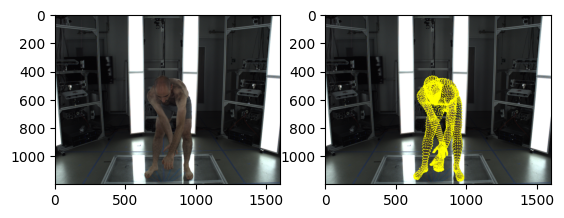

In [86]:
ds = EHFDataset(
    data_path='/mnt/vol_d/datasets/EHF',
    smplx_model_path='/mnt/vol_c/projects/synth-smplerx/common/utils/human_model_files/smplx/',
)
len(ds)
img, box, v3, v2 = ds[5]

fig, axes = plt.subplots(ncols=2)
axes[0].imshow(img)
axes[1].imshow(plot_points_on_image(img, v2))

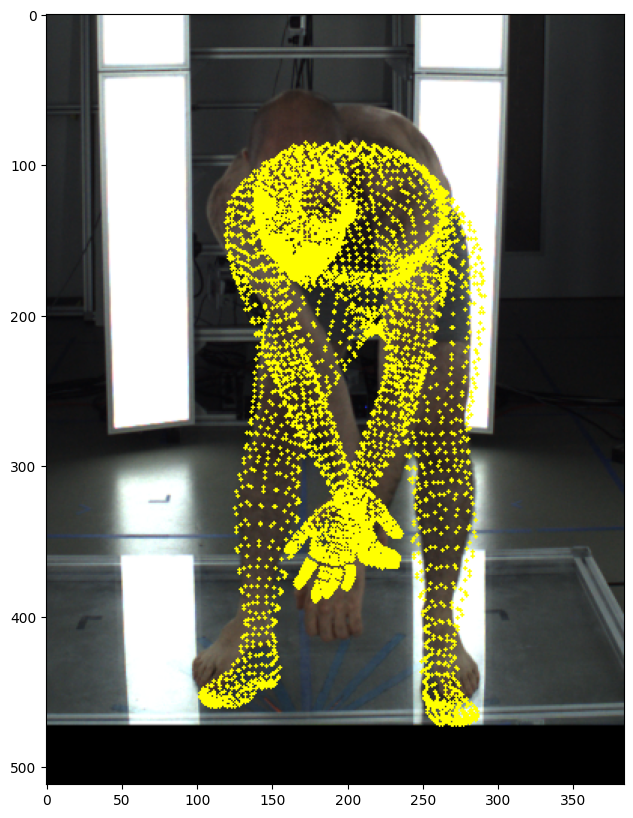

In [87]:
img_out, v, out = make_pred(img, box, preserve_aspect_ratio=False, bbox_scale=1.2)
img_out = (img_out[0].permute(1, 2, 0).cpu().numpy() * 255).astype(np.uint8)
v2 = v[:, :2] / v[:, 2:]

# mulitply by 2 because focal nad princpt are defined for input_body_shape and not inout image shape
focal = 2 * out['focal']
princpt =  2* out['princpt']

v2 = focal * v2 + princpt
plt.figure(figsize=(10, 10))
plt.imshow(plot_points_on_image(img_out, v2, radius=1), )

In [88]:
out

{'global_orient': array([[-2.5834327 , -0.02753305,  0.2614133 ]], dtype=float32),
 'body_pose': array([[-1.1308477 ,  0.10239088,  0.20765202],
        [-1.3041    ,  0.04122901, -0.1681476 ],
        [ 1.2436541 , -0.00331658,  0.04684754],
        [ 0.8018    ,  0.0768046 , -0.1305795 ],
        [ 0.85764444, -0.11801293,  0.09267547],
        [-0.18333445,  0.0264632 , -0.00764231],
        [-0.07340202,  0.1118513 ,  0.00365723],
        [ 0.07874896, -0.11914793,  0.03562563],
        [-0.15476058, -0.00133198,  0.00378472],
        [ 0.01988667,  0.0050671 , -0.05527669],
        [ 0.03174899,  0.01241208,  0.02484161],
        [ 0.2035825 , -0.08357408,  0.07290323],
        [-0.2495935 , -0.71676993,  0.09179153],
        [-0.28863958,  0.69109565,  0.00475312],
        [-0.15266101, -0.03055906, -0.02102172],
        [-0.32251045, -0.8145507 , -0.552346  ],
        [-0.14255111,  0.9431204 ,  0.6441024 ],
        [-0.16155492, -0.38292775,  0.02970322],
        [-0.17527215, 